In [6]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#from bokeh.plotting import figure, curdoc                                                                                                                                
#from bokeh.palettes import Spectral6                                                                                                                                     
#from bokeh.models import ColumnDataSource, HoverTool, Div 
import json
import argparse
import os,sys

%matplotlib inline

In [7]:
sys.path.append('/Users/clint/machine_learning_review/styles/')

In [8]:
df = pd.read_csv('../data/shot_logs.csv',header=0)

In [9]:
def ConvertShotResultToInt(x):
    if x=='made':
        return 1
    else:
        return 0


In [10]:
df['MADE_INT'] = df.loc[:,'SHOT_RESULT'].apply(ConvertShotResultToInt)

In [67]:
import ml_style as sty
mpl.rcParams.update(sty.style)

In [22]:
df_AccDist= df.loc[:,['MADE_INT',"SHOT_DIST"]].groupby( np.digitize(df.loc[:,'SHOT_DIST'],np.linspace(0,50,26)) )
#acc = df_group.loc[:,'MADE_INT'].mean()

In [23]:
acc = df_AccDist.mean()

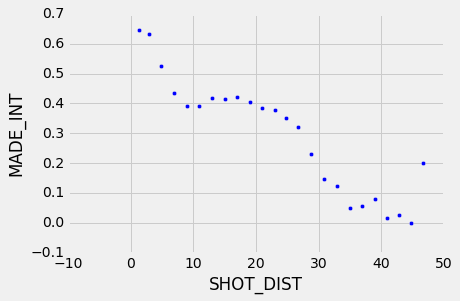

In [68]:
fig = plt.figure()

acc.plot(kind='scatter',x='SHOT_DIST',y='MADE_INT')

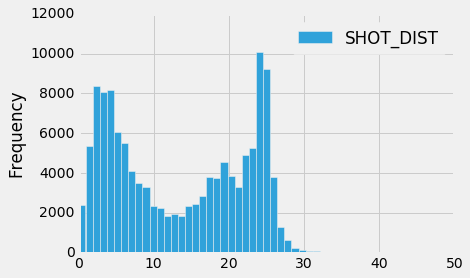

In [69]:
df.plot(kind='hist',y='SHOT_DIST',bins=50)

In [28]:
test = 'MAR 04, 2015 - CHA @ BKN'

In [29]:
team = (test.split(' - ')[1]).split(' @ ')[1]

In [30]:
team

'BKN'

In [31]:
def getOffenseTeam(input):
        if input.find('@')!=-1:
            team = (input.split(' - ')[1]).split(' @ ')[0]
            return team
        else:
            team = (input.split(' - ')[1]).split(' vs. ')[0]
            return team

def getDefenseTeam(input):
        if input.find('@')!=-1:
            team = (input.split(' - ')[1]).split(' @ ')[1]
            return team
        else:
            team = (input.split(' - ')[1]).split(' vs. ')[1]
            return team

In [32]:
df['SHOOTING_TEAM'] = df.loc[:,'MATCHUP'].apply(getOffenseTeam)

In [33]:
df['DEFENSE_TEAM']  = df.loc[:,'MATCHUP'].apply(getDefenseTeam)

In [34]:
def getTeamDF(df,team):
    df_team = df[ (df['SHOOTING_TEAM']==team)]
    return df_team

In [35]:
df_cha = getTeamDF(df,'CHA')

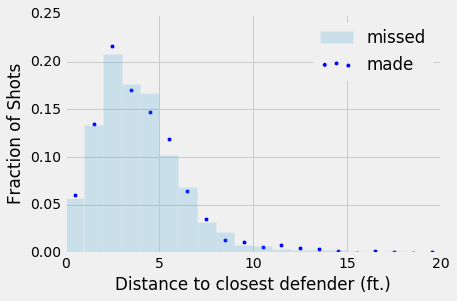

In [70]:
df_cha_made = df_cha.query('MADE_INT==1').query('CLOSE_DEF_DIST<=20')
df_cha_miss = df_cha.query('MADE_INT==0 & CLOSE_DEF_DIST<=20')
fig = plt.figure()
n,temp,patches=plt.hist(df_cha_made.CLOSE_DEF_DIST,alpha=0.5,bins=range(0,21),label='made',normed=1)
#print ax[1]
fig.clf()
bins=[x for x in np.arange(0.5,20.5,1)]
df_cha_miss.plot(xlim=[0,20],ylim=[0,0.25],kind='hist',y='CLOSE_DEF_DIST',bins=range(0,21),alpha=0.2,label='missed',normed=1)
plt.scatter(bins,n,label='made')
plt.legend()
plt.xlabel('Distance to closest defender (ft.)')
plt.ylabel('Fraction of Shots')


In [56]:
group = df_cha.loc[:,['SHOT_DIST','CLOSE_DEF_DIST']].groupby('SHOT_DIST')

In [57]:
dist=group.mean()

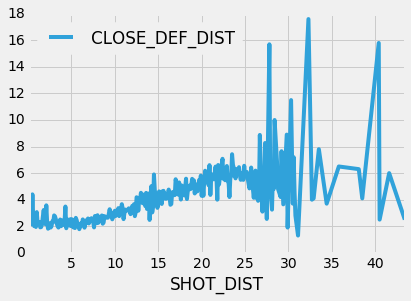

In [58]:
dist.plot()

In [42]:
acc_v_def_group = df.loc[:,['MADE_INT','CLOSE_DEF_DIST']].groupby('CLOSE_DEF_DIST')

In [43]:
acc_v_def = acc_v_def_group.mean()

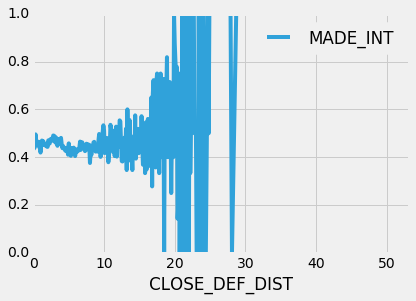

In [44]:
acc_v_def.plot()

In [45]:
df_cha_wins = df_cha.query('W == "W"')
df_cha_losses = df_cha.query('W == "L"')

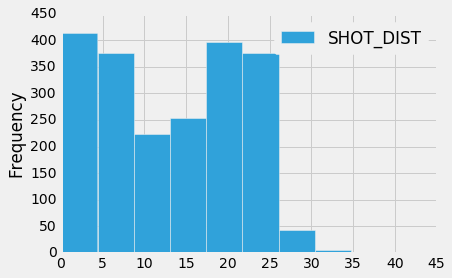

In [46]:
df_cha_wins.plot(kind='hist',y='SHOT_DIST')

In [47]:
shotclockbins = np.linspace(0,24,25)
acc_v_sc_group = df.loc[:,['MADE_INT']].groupby(np.digitize(df.loc[:,'SHOT_CLOCK'],shotclockbins))
acc_v_sc = acc_v_sc_group.mean()


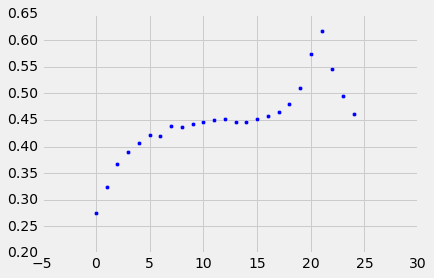

In [48]:
plt.scatter(x=shotclockbins,y=acc_v_sc)

In [49]:
#the goal is to measure a probability that shooter X differs from the average. To start I'll
#just focus on shots within 10 ft of the hoop, an do one bin, but then want to extend to a 
#binned analysis


#first get the league average
df_acc_league = df.query("SHOT_DIST < 5")
df_acc_league= df_acc_league.loc[:,['MADE_INT',"SHOT_DIST"]].groupby( np.digitize(df_acc_league.loc[:,'SHOT_DIST'],np.linspace(0,5,1)) )
league_acc = df_acc_league.mean()
league_pct = league_acc.MADE_INT.values[0]

#now get steph curry's percentage
df_acc_steph = df.query("SHOT_DIST < 5 & player_name =='stephen curry'")
df_acc_steph = df_acc_steph.loc[:,['MADE_INT','SHOT_DIST']].groupby( np.digitize(df_acc_steph.loc[:,'SHOT_DIST'],np.linspace(0,5,1)) )
steph_acc = df_acc_steph.mean().MADE_INT.values[0]
steph_std = df_acc_steph.std().MADE_INT.values[0]


In [50]:
#want to get intervals between made shots, first get df for steph curry and made shots
df_sc_made = df.query('player_name=="stephen curry" & MADE_INT==1')
#print df_sc_made.head()
def getTimeDiff(p1,p2,m1,m2,s1,s2):
        diff = (p2-p1)*12 + (m1-m2) + (s1-s2)/60.
        return diff
iter=0
timeDiffs=[]
for i in range(0,len(df_sc_made)):
    if i==0:
        p = (int(df_sc_made.iloc[i,6])-1)*12 
        m = 12-int(df_sc_made.iloc[i,7].split(':')[0])
        s = float(df_sc_made.iloc[i,7].split(':')[1])/60.
        timeDiff= p + m + s
    else:
        if df_sc_made.iloc[i-1,0]==df_sc_made.iloc[i,0]: #same game
            p1 = int(df_sc_made.iloc[i-1,6])
            p2 = int(df_sc_made.iloc[i,6])
            gc1 = df_sc_made.iloc[i-1,7].split(':')
            m1 = int(gc1[0])
            s1 = int(gc1[1])
            gc2 = df_sc_made.iloc[i,7].split(':')
            m2 = int(gc2[0])
            s2 = int(gc2[1])
            if i==1:
                print p1,p2,m1,m2,s1,s2
            timeDiff= getTimeDiff(p1,p2,m1,m2,s1,s2)
        else: #start of game - treat as first entry
            p = (int(df_sc_made.iloc[i,6])-1)*12 
            m = 12-int(df_sc_made.iloc[i,7].split(':')[0])
            s = float(df_sc_made.iloc[i,7].split(':')[1])/60.
            timeDiff= p + m + s
    timeDiffs.append(timeDiff)

df_sc_made['INTERVAL']=timeDiffs

1 1 5 5 34 0


/Users/clint/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


5.01592198582


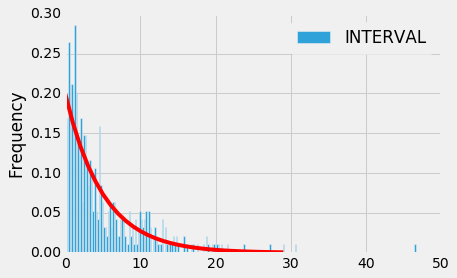

In [51]:
df_sc_made.plot(kind='hist',y='INTERVAL',bins=np.linspace(0,48,240),normed=1)
meanInterval = np.mean(timeDiffs)
print meanInterval
plt.plot(map(lambda x: (1./meanInterval)*np.exp(-x/meanInterval), range(0,30)),color='red')